## Select galaxies (for the LSLGA) from G<18 Gaia sources

The goal of this notebook is to develop a set of cuts that we can use to find galaxies which will otherwise be "forced PSF" in DR9.

Before running this notebook, some preparatory work needs to be done to generate a set of sweep catalogs containing *just* *G<18* Gaia stars. The details are documented in `/global/cfs/cdirs/desi/users/ioannis/lslga-from-gaia/README`, but briefly, we select ~22M Gaia point sources using the following cuts:

```
BRICK_PRIMARY == True &
GAIA_PHOT_G_MEAN_MAG > 0 & 
GAIA_PHOT_G_MEAN_MAG < 18 & 
GAIA_ASTROMETRIC_EXCESS_NOISE < 10**0.5 &
(MASKBITS & 0x2) == 0 &
(MASKBITS & 0x2000) == 0 &
FLUX_R > 0 &
FLUX_W1 > 0 &
ALLMASK_G == 0
ALLMASK_R == 0
ALLMASK_z == 0
NOBS_G > 0
NOBS_R > 0
NOBS_Z > 0
```

Once that's done, this notebook can be run.

In [17]:
import os, pdb
import fitsio
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from astropy.table import vstack, Table
from astrometry.libkd.spherematch import match_radec

In [18]:
import seaborn as sns
sns.set(context='talk', style='ticks', font_scale=1.4)
%matplotlib inline

In [19]:
dr8dir = '/global/project/projectdirs/cosmo/data/legacysurvey/dr8/'
outdir = '/global/project/projectdirs/desi/users/ioannis/lslga-from-gaia'

#### Read the SDSS training sample.

Train our selection using the set of spectroscopically confirmed SDSS galaxies which would otherwise be forced PSF.

In [20]:
def read_gaia_psf_sdss(clobber=False):
    outfile = os.path.join(outdir, 'dr8-gaia-psf-sdss.fits')
    if os.path.isfile(outfile) and not clobber:
        out = Table.read(outfile)
        print('Read {} galaxies from {}'.format(len(out), outfile))
    else:
        sdss = fitsio.read('/global/cfs/cdirs/cosmo/work/sdss/cats/specObj-dr14.fits')
        out = []
        for region in ('north', 'south'):
            print('Working on {}'.format(region))
            ext = fitsio.read(os.path.join(dr8dir, region, 'external', 
                                           'survey-dr8-{}-specObj-dr14.fits'.format(region)))
            keep = np.where((ext['GAIA_PHOT_G_MEAN_MAG'] > 0) * 
                            (ext['GAIA_PHOT_G_MEAN_MAG'] < 18) * 
                            (ext['GAIA_ASTROMETRIC_EXCESS_NOISE'] < 10.**0.5) * 
                            (ext['FLUX_W1'] > 0) * 
                            (ext['FLUX_R'] > 0) * 
                            ((sdss['PRIMTARGET'] & 2**6) != 0) * 
                            (sdss['Z'] > 0.001) * (sdss['Z'] < 1) * 
                            (sdss['ZWARNING'] == 0))[0]
            if len(keep) > 0:
                out.append(Table(ext[keep]))
        out = vstack(out)
        out.write(outfile, overwrite=True)
    return out               

In [21]:
%time specz = read_gaia_psf_sdss(clobber=False)
#m1, m2, _ = match_radec(specz['RA'], specz['DEC'], specz['RA'], specz['DEC'], 1/3600, nearest=False)
#print(len(m1), len(specz))

Read 631 galaxies from /global/project/projectdirs/desi/users/ioannis/lslga-from-gaia/dr8-gaia-psf-sdss.fits
CPU times: user 96.3 ms, sys: 3.89 ms, total: 100 ms
Wall time: 144 ms


In [22]:
#ext = fitsio.read(os.path.join(dr8dir, 'north', 'external', 'survey-dr8-north-specObj-dr14.fits'))
#m1, m2, _ = match_radec(ext['RA'], ext['DEC'], ext['RA'], ext['DEC'], 1/3600, nearest=False)
#print(len(m1), len(ext))

#### Next, assemble the full catalog of forced-PSF Gaia sources from DR8.

Merge the sweeps together that were generated using `/global/cfs/cdirs/desi/users/ioannis/lslga-from-gaia/build-gaia-psf`. For DR8 this step takes approximately 7 minutes to generate it for the first time, or roughly 45 seconds to read it in.

In [23]:
def read_gaia_psf(clobber=False):    
    outfile = os.path.join(outdir, 'dr8-gaia-psf.fits')
    if os.path.isfile(outfile) and not clobber:
        out = Table(fitsio.read(outfile))
        print('Read {} objects from {}'.format(len(out), outfile))
    else:
        out = []
        for region in ['north', 'south']:
            print('Working on {}'.format(region))
            sweepdir = os.path.join(outdir, 'sweep-{}-gaia'.format(region))
            catfile = glob(os.path.join(sweepdir, 'sweep*.fits'))
            for ii, ff in enumerate(catfile):
                if ii % 50 == 0:
                    print('{} / {}'.format(ii, len(catfile)))
                cc = fitsio.read(ff)
                if len(cc) > 0:
                    out.append(Table(cc))
        out = vstack(out)
        print('Writing {} objects to {}'.format(len(out), outfile))
        out.write(outfile, overwrite=True)
    return out

In [24]:
%time cat = read_gaia_psf(clobber=True)

Working on north
0 / 237
50 / 237
100 / 237
150 / 237
200 / 237
Working on south
0 / 422
50 / 422
100 / 422
150 / 422
200 / 422
250 / 422
300 / 422
350 / 422
400 / 422
Writing 22251430 objects to /global/project/projectdirs/desi/users/ioannis/lslga-from-gaia/dr8-gaia-psf.fits
CPU times: user 5min 41s, sys: 58.5 s, total: 6min 40s
Wall time: 7min 5s


### Make some plots and develop the selection.

Cut 1: x>0.25
Cut 2: y>-1.6667x + 2.1167
Cut 3: y>0.00
Selected SDSS-specz galaxies: N=453/631 (71.7908%)
Candidate LSLGA-Gaia galaxies: N=1983/22251430 (0.0089%)
Writing /global/project/projectdirs/desi/users/ioannis/lslga-from-gaia/dr8-gaia-psf-galaxies.png


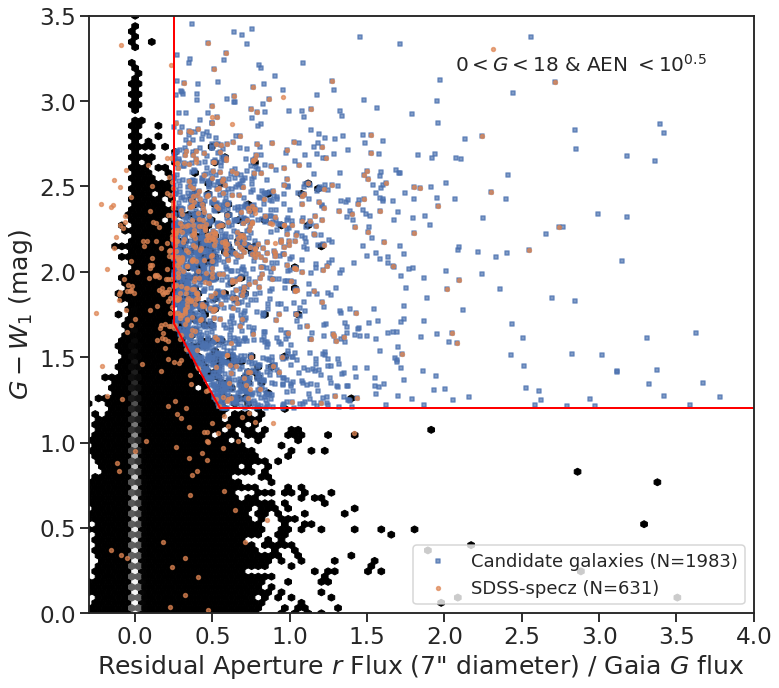

In [25]:
def getmags(cat):
    gmag = cat['GAIA_PHOT_G_MEAN_MAG']
    bp = cat['GAIA_PHOT_BP_MEAN_MAG']
    rp = cat['GAIA_PHOT_RP_MEAN_MAG']
    rmag = 22.5-2.5*np.log10(cat['FLUX_R'])
    Wmag = 22.5-2.5*np.log10(cat['FLUX_W1'])
    resid = cat['APFLUX_RESID_R'][:, 5]/10**(-0.4*(gmag-22.5))
    #resid = cat['APFLUX_RESID_R'][:, 7]/cat['FLUX_R']
    chi2 = cat['RCHISQ_R']
    return gmag-Wmag, bp-rp, resid, chi2

gW, bprp, resid, chi2 = getmags(cat)
sgW, sbprp, sresid, schi2 = getmags(specz)

xlim, ylim = (-0.3, 4), (0, 3.5)

# north cuts
#x0, x1, x2, x3 = (0.2, 0.2, 0.55, 5.0)
#y0, y1, y2, y3 = (  _, 1.7, 1.0, 1.0)
# north/south
x0, x1, x2, x3 = (0.25, 0.25, 0.55, 5.0)
y0, y1, y2, y3 = (  _, 1.7, 1.2, 1.2)

c1 = np.polyfit([x1, x2], [y1, y2], 1)
c2 = np.polyfit([x2, x3], [y2, y3], 1)
print('Cut 1: x>{:.2f}'.format(x0))
print('Cut 2: y>{:.4f}x + {:.4f}'.format(c1[0], c1[1]))
print('Cut 3: y>{:.2f}'.format(c2[0]))
#print(c1, c2)

J = np.where((resid > x0) * (gW > np.polyval(c1, resid)) * (gW > np.polyval(c2, resid)))[0]
I = np.where((sresid > x0) * (sgW > np.polyval(c1, sresid)) * (sgW > np.polyval(c2, sresid)))[0]

print('Selected SDSS-specz galaxies: N={}/{} ({:.4f}%)'.format(len(I), len(specz), 100*len(I)/len(specz)))
print('Candidate LSLGA-Gaia galaxies: N={}/{} ({:.4f}%)'.format(len(J), len(cat), 100*len(J)/len(cat)))
#print(len(J), len(cat), len(J)/len(cat))

fig, ax = plt.subplots(figsize=(12, 10))
ax.hexbin(resid, gW, mincnt=3, cmap='Greys_r',
          extent=np.hstack((xlim, ylim)))
ax.scatter(resid[J], gW[J], s=10, marker='s', alpha=0.7,
           label='Candidate galaxies (N={})'.format(len(J)))
ax.scatter(sresid, sgW, s=15, marker='o', alpha=0.7,
           label='SDSS-specz (N={})'.format(len(specz)))
ax.plot([x0, x0], [y1, ylim[1]], color='red', lw=2)
ax.plot([x1, x2], [y1, y2], color='red', lw=2)
ax.plot([x2, x3], [y2, y3], color='red', lw=2)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel(r'Residual Aperture $r$ Flux (7" diameter) / Gaia $G$ flux')
ax.set_ylabel(r'$G - W_{1}$ (mag)')
#_ = ax.set_title(r'$0 < G < 18$ & AEN $< 10^{0.5}$')
ax.text(0.93, 0.9, r'$0 < G < 18$ & AEN $< 10^{0.5}$', 
        ha='right', va='bottom', transform=ax.transAxes,
        fontsize=20)
hh, ll = ax.get_legend_handles_labels()
#print(ll)
ax.legend(hh[1:], ll[1:], loc='lower right', fontsize=18)

fig.subplots_adjust(left=0.13, bottom=0.12, top=0.95)

pngfile = os.path.join(outdir, 'dr8-gaia-psf-galaxies.png')
print('Writing {}'.format(pngfile))
fig.savefig(pngfile)

Might as well add all the SDSS galaxies to the output sample, irrespective of where they lie.

In [26]:
K = []
for brickid in set(specz['BRICKID']):
    W = np.where(brickid == specz['BRICKID'])[0]
    for ww in W:
        K.append(np.where((cat['BRICKID'] == brickid) * (cat['OBJID'] == specz['OBJID'][ww]))[0])
K = np.unique(np.hstack(K))
print('Matched {} unique galaxies from the parent SDSS-Gaia sample.'.format(len(K)))

Matched 599 unique galaxies from the parent SDSS-Gaia sample.


In [27]:
Jfinal = np.unique(np.hstack((J, K)))
print('Original sample = {}, final sample = {}'.format(len(J), len(Jfinal)))

Original sample = 1983, final sample = 2155


In [28]:
#m1, m2, _ = match_radec(cat['RA'][J], cat['DEC'][J], specz['RA'], specz['DEC'], 1/3600.0, nearest=True)
#missed = np.delete(np.arange(len(specz)), m2)
#print('Selected SDSS galaxies {}/{}, missing {}.'.format(len(m2), len(specz), len(missed)))
#k1, k2, _ = match_radec(cat['RA'], cat['DEC'], specz['RA'][missed], specz['DEC'][missed], 
#                        1/3600.0, nearest=True)
#print('Found {}/{} of the missed SDSS galaxies.'.format(len(k2), len(missed)))

In [29]:
# check
#m1, m2, _ = match_radec(cat['RA'][Jfinal], cat['DEC'][Jfinal], specz['RA'], specz['DEC'], 2/3600.0, nearest=True)
#print(len(m2), len(specz))
#missed = np.delete(np.arange(len(specz)), m2)
#specz[missed]
#assert(len(m2)==len(specz))

In [30]:
for ra, dec in zip(cat['RA'][Jfinal[:500]], cat['DEC'][Jfinal[:500]]):
    if dec < 30:
        print(ra, dec)

In [31]:
# We get this broadline QSO now!!
# http://legacysurvey.org/viewer-dev?ra=178.6654&dec=34.8714&layer=dr8-resid&zoom=14&lslga&masks-dr9&spectra
#match_radec(cat['RA'][Jfinal], cat['DEC'][Jfinal], 178.6654, 34.8714, 1/3600, nearest=True)

#### Write out.

In [32]:
outfile = os.path.join(outdir, 'dr8-gaia-psf-galaxies.fits')
print('Writing {} galaxies to {}'.format(len(Jfinal), outfile))
cat[Jfinal].write(outfile, overwrite=True)

Writing 2155 galaxies to /global/project/projectdirs/desi/users/ioannis/lslga-from-gaia/dr8-gaia-psf-galaxies.fits
